# AMAZON APPAREL RECOMMENDATION USING TEXT AND IMAGE BASED SIMILARITIES
DATA : https://docs.aws.amazon.com/AWSECommerceService/latest/DG/ItemSearch.html
#get data using the above amazon's product api


In [103]:
### importing libraries
import pandas as pd
import json
from PIL import Image
from io import BytesIO


import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

import nltk, os, time, math, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)



In [4]:
## read scraped data from amazon product API in json format
### scareped only women's tops (using keyowrd)

data = pd.read_json('tops_fashion.json')
print(data.shape,'\n')
print(data.info())

data.head()

(183138, 19) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183138 entries, 0 to 183137
Data columns (total 19 columns):
asin                 183138 non-null object
author               1 non-null object
availability         24532 non-null object
availability_type    24559 non-null object
brand                182987 non-null object
color                64956 non-null object
editorial_reivew     180380 non-null object
editorial_review     2758 non-null object
formatted_price      28395 non-null object
large_image_url      183138 non-null object
manufacturer         42899 non-null object
medium_image_url     183138 non-null object
model                62370 non-null object
product_type_name    183138 non-null object
publisher            42899 non-null object
reviews              183138 non-null object
sku                  363 non-null object
small_image_url      183138 non-null object
title                183138 non-null object
dtypes: object(19)
memory usage: 26.5+ MB
None


,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
0,B016I2TS4W,None,None,None,FNC7C,None,NaN,Minions Como Superheroes Ironman Women's O Nec...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Long Sleeve R...
1,B01N49AI08,None,None,None,FIG Clothing,None,NaN,Sizing runs on the small side. FIG® recommends...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Izo Tunic
2,B01JDPCOHO,None,None,None,FIG Clothing,None,NaN,Sizing runs on the small side. FIG® recommends...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Won Top
3,B01N19U5H5,None,None,None,Focal18,None,NaN,100% Brand New & Fashion<br> Quantity: 1 Piece...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[True, https://www.amazon.com/reviews/iframe?a...",None,https://images-na.ssl-images-amazon.com/images...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...
4,B004GSI2OS,None,Usually ships in 6-10 business days,now,FeatherLite,Onyx Black/ Stone,NaN,,$26.26,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...


In [5]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
print(data.head())
print(data.shape)

         asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Wom

In [6]:
## EDA on product type
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [7]:
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [8]:
print(data['product_type_name'].value_counts().nlargest(10))

SHIRT                         167794
APPAREL                         3549
BOOKS_1973_AND_LATER            3336
DRESS                           1584
SPORTING_GOODS                  1281
SWEATER                          837
OUTERWEAR                        796
OUTDOOR_RECREATION_PRODUCT       729
ACCESSORY                        636
UNDERWEAR                        425
Name: product_type_name, dtype: int64


In [9]:
## basic stats on brand
print(data['brand'].describe(), '\n')
print(data['brand'].value_counts().nlargest(10))

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object 

Zago                         223
XQS                          222
Yayun                        215
YUNY                         198
XiaoTianXin-women clothes    193
Generic                      192
Boohoo                       190
Alion                        188
Abetteric                    187
TheMogan                     187
Name: brand, dtype: int64


In [10]:
### color stats
print(data['color'].describe(),'\n')
print(data['color'].value_counts().nlargest(10))

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object 

Black    13207
White     8616
Blue      3570
Red       2289
Pink      1842
Grey      1499
*         1388
Green     1258
Multi     1203
Gray      1189
Name: color, dtype: int64


In [11]:
## price stats
print(data['formatted_price'].describe(),'\n')
print(data['formatted_price'].value_counts().nlargest(10))

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object 

$19.99    945
$9.99     749
$9.50     601
$14.99    472
$7.50     463
$24.99    414
$29.99    370
$8.99     343
$9.01     336
$16.99    317
Name: formatted_price, dtype: int64


In [12]:
## Title
print(data['title'].describe(),'\n')


count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object 



In [13]:
### consider products which only have price info
data = data.loc[~data['formatted_price'].isnull()]
print(data.shape)

(28395, 7)


In [14]:
## consider only those products which have price information
data = data.loc[~data['color'].isnull()]
print('final data after removing null values in price and color are:' , data.shape)

final data after removing null values in price and color are: (28385, 7)


In [15]:
## save formatted data to disk

data.to_pickle('28k_data')

In [16]:
"""## downlaod images for these 28k data points(using ASIN)
from PIL import Image
import requests, os
from io import BytesIO

for idx, row in images.iterrows():
    url = row['large_image_url']
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.save('images/28k_images/'+ row['asin']+'.jpeg')"""

"## downlaod images for these 28k data points(using ASIN)\nfrom PIL import Image\nimport requests, os\nfrom io import BytesIO\n\nfor idx, row in images.iterrows():\n    url = row['large_image_url']\n    response = requests.get(url)\n    img = Image.open(BytesIO(response.content))\n    img.save('images/28k_images/'+ row['asin']+'.jpeg')"

In [17]:
## removing duplicate entries in title
data =pd.read_pickle('28k_data')
print(sum(data.duplicated('title')))
      

2325


In [18]:
### consider onky those titles which have len>4 , as smaller title len doesn't give much info about the product

data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
data_sorted.sort_values('title', inplace = True, ascending = False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


In [19]:
## store indexes
idx = []
for i , row in data_sorted.iterrows():
    idx.append(i)

In [20]:
## remove duplicates whose title only differ in last few words (diff in len(title)<2)
import itertools
dedupe_asins_1 = []
i=j=0
data_points = data_sorted.shape[0]
while i < data_points and j < data_points:
    prev_i = i
    
    ## store words of ith string
    a = data['title'].loc[idx[i]].split()
    ## search for similar titles
    while j < data_points:
        b = data['title'].loc[idx[j]].split()
        length = max(len(a), len(b))
        count = 0
        # map corresponding words in both strings
        for k in itertools.zip_longest(a,b):
            if(k[0]==k[1]):
                count +=1
        ## if difference in both strings last few words is less than 2 remove them
        if (length -count)>2:
            dedupe_asins_1.append(data_sorted['asin'].loc[idx[i]])
            
            ## start searching for similar titles
            i = j
            break
        else:
            j +=1
    if prev_i==i:
        break
        

In [21]:
data = data.loc[data['asin'].isin(dedupe_asins_1)]
print('data points after removing diff in len<2 are:' , data.shape[0])

data points after removing diff in len<2 are: 17592


In [22]:
## save to disk
data.to_pickle('17k_data')


In [23]:
## also removing those title which have string length difference <3 , previously we removed based on last few words


# TEXT PREPROCESSING


In [24]:
data = pd.read_pickle('17k_data')


In [26]:
## removing stop words
stop_words = set(stopwords.words('english'))

def text_preprocessing(text , idx, column):
    if type(text) is not int:
        string = ""
        for words in text.split():
            word = ("".join(e for e in words if e.isalnum()))
            word = word.lower()
            if not word in stop_words:
                string += word +" "
        data[column][idx] = string
        


In [27]:
%%time
for idx , row in data.iterrows():
    text_preprocessing(row['title'], idx, 'title')


CPU times: user 6.43 s, sys: 97 ms, total: 6.52 s
Wall time: 6.57 s


In [28]:
print(data.head())
print(data.shape)

          asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
43  B0079BMKDS                  FeatherLite              White   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
43  https://images-na.ssl-images-amazon.com/images...           APPAREL   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   wome

In [29]:
data.to_pickle('17k_processed_data')

# TEXT BASED PRODUCT SIMILARITY


In [30]:
data = pd.read_pickle('17k_processed_data')


In [82]:
### defining utility functions to diaply images , heatmaps
from matplotlib import gridspec
import seaborn as sns
import requests


## display image
def display_image(url,ax, fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    
## plot heat map

def heat_map(keys, values, labels,url, text):
    gs = gridspec.GridSpec(2,2,width_ratios = [4,1], height_ratios=[4,1])
    fig = plt.figure(figsize=(25,3))
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]), annot = np.array([labels]))
    ax.set_xticklabels(keys)
    ax.set_title(text)
    
    ## plot image of apparel
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_image(url,ax, fig)
    plt.show()
    
def heat_map_image(doc_id, vec1, vec2, url, text ,model):
    intersect = set(vec1.keys()) & set(vec2.keys())
    for i in vec2:
        if i not in intersect:
            vec2[i]=0
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    
    if model=='bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in tfidf_title_vect.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vect.vocabulary_[x]])
            else:
                labels.append(0)
    elif model=='idf':
        labels = []
        for x in vec2.keys():
            if x in idf_title_vect.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vect.vocabulary_[x]])
            else:
                labels.append(0)
    heat_map(keys, values , labels, url, text)
    
def text_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

def get_result(doc_id, content_a, content_b, url , model):
    text1 =content_a
    text2 = content_b
    vect1 = text_vector(text1)
    vect2 = text_vector(text2)
    
    heat_map_image(doc_id, vect1, vect2, url, text2, model)
    
                
                                

# BAG OF WORDS MODEL 

In [61]:
title_vect = CountVectorizer()
title_features = title_vect.fit_transform(data['title'])
title_features.get_shape()

(17592, 12927)

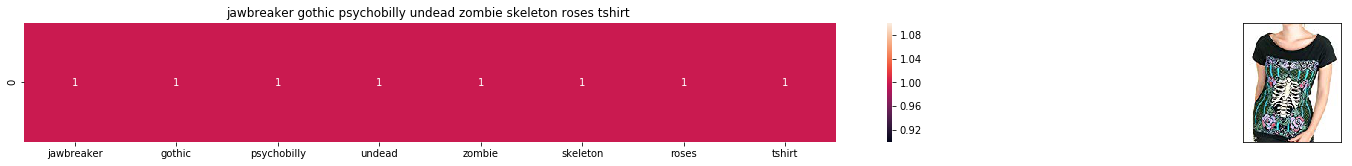

ASIN : B01D3R5VXC
Brand: Jawbreaker
Title: jawbreaker gothic psychobilly undead zombie skeleton roses tshirt 
Euclidean similarity with the query image : 12566


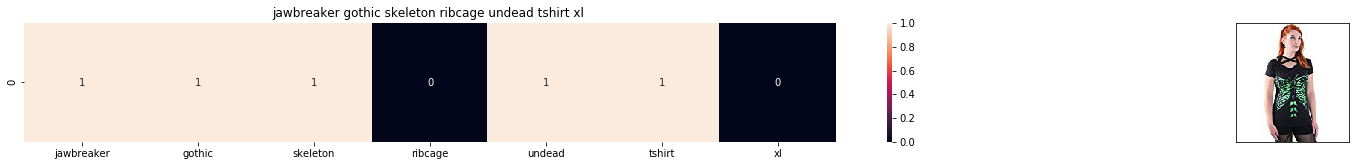

ASIN : B072YV132Q
Brand: Jawbreaker
Title: jawbreaker gothic skeleton ribcage undead tshirt xl 
Euclidean similarity with the query image : 10798


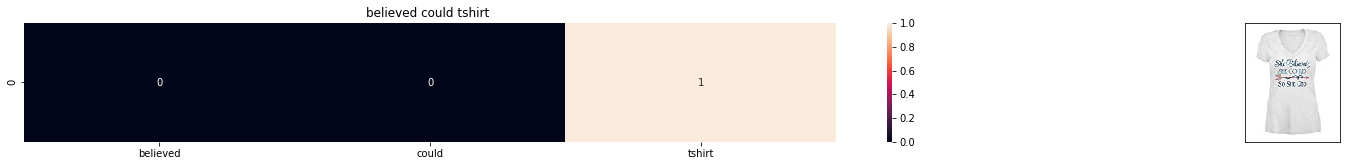

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 5474


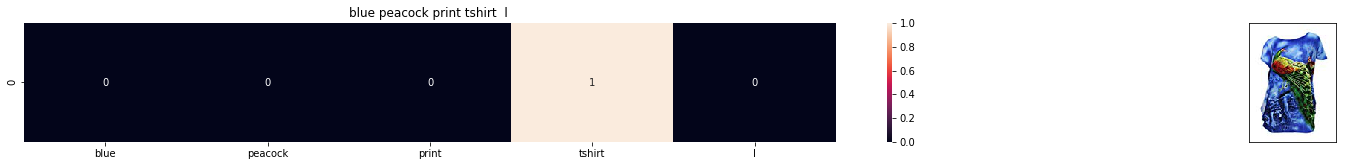

ASIN : B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt  l 
Euclidean similarity with the query image : 14324


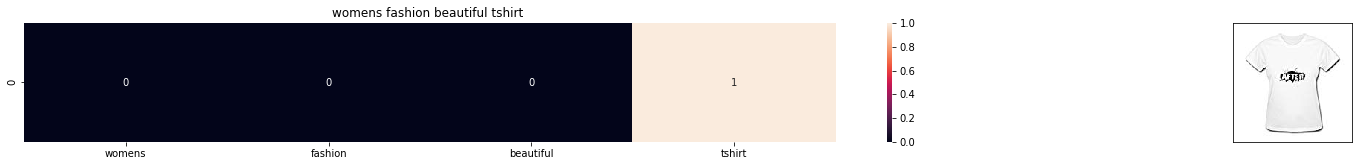

ASIN : B074VMNZN9
Brand: simple
Title: womens fashion beautiful tshirt 
Euclidean similarity with the query image : 12767


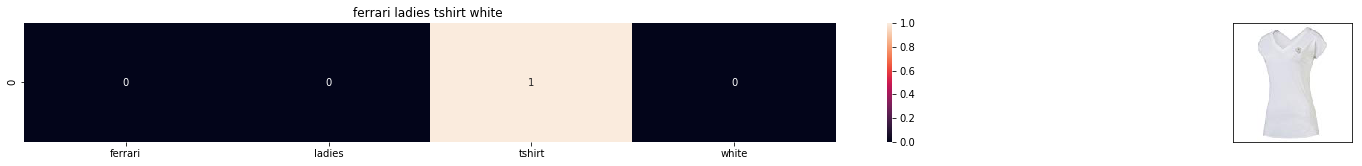

ASIN : B015YKMU80
Brand: PUMA
Title: ferrari ladies tshirt white 
Euclidean similarity with the query image : 14255


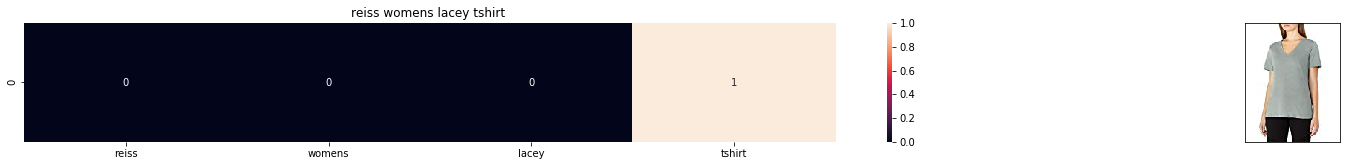

ASIN : B072FMQ8FN
Brand: Reiss
Title: reiss womens lacey tshirt 
Euclidean similarity with the query image : 13567


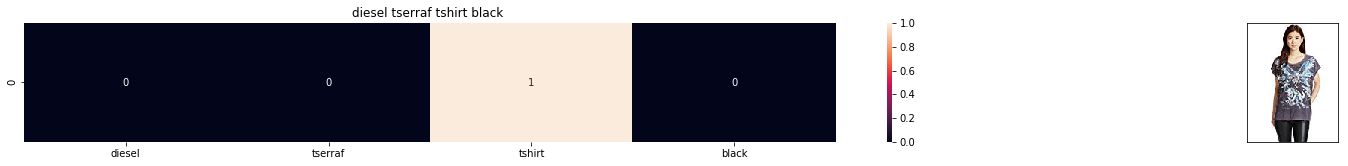

ASIN : B017X8PW9U
Brand: Diesel
Title: diesel tserraf tshirt black 
Euclidean similarity with the query image : 9039


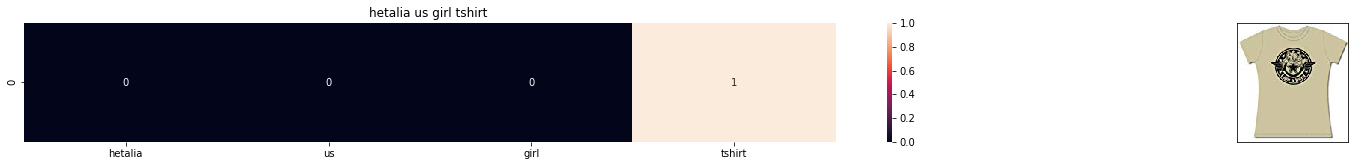

ASIN : B005IT8OBA
Brand: Hetalia
Title: hetalia us girl tshirt 
Euclidean similarity with the query image : 11634


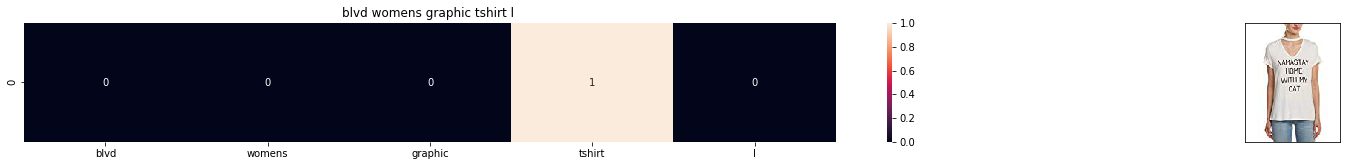

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 15538


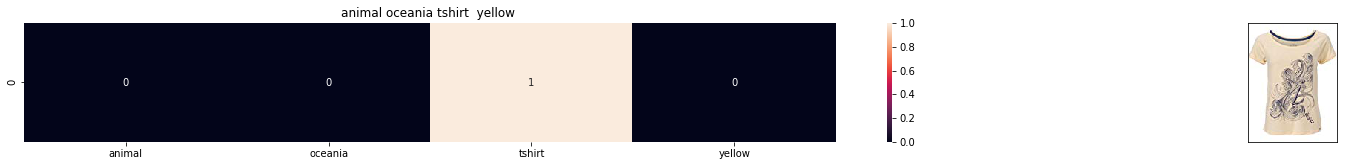

ASIN : B06X6GX6WG
Brand: Animal
Title: animal oceania tshirt  yellow 
Euclidean similarity with the query image : 1281


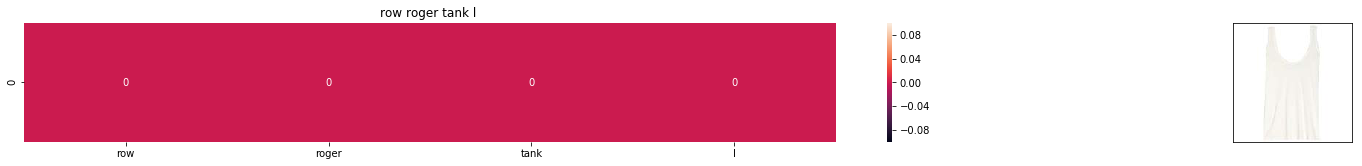

ASIN : B0742M5H4Q
Brand: The Row
Title: row roger tank l 
Euclidean similarity with the query image : 10508


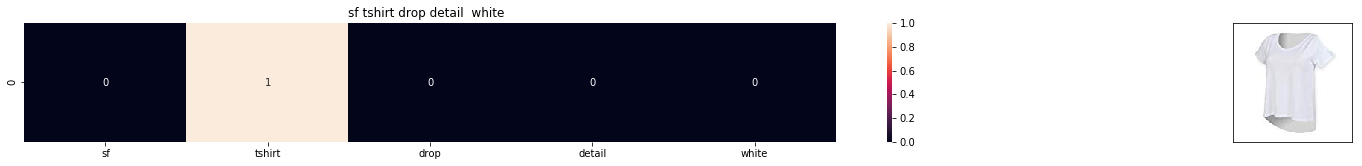

ASIN : B00LS76IBE
Brand: SF
Title: sf tshirt drop detail  white  
Euclidean similarity with the query image : 8404


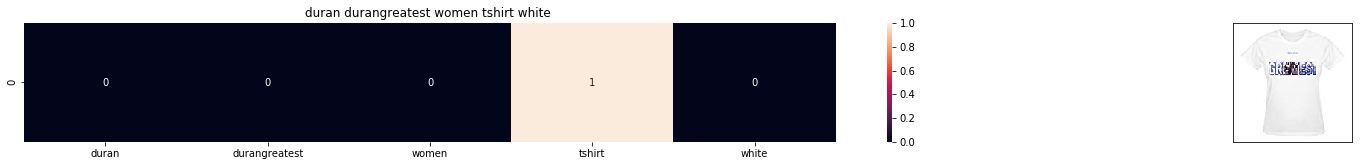

ASIN : B01H51HDN8
Brand: Tony Arden
Title: duran durangreatest women tshirt white 
Euclidean similarity with the query image : 9277


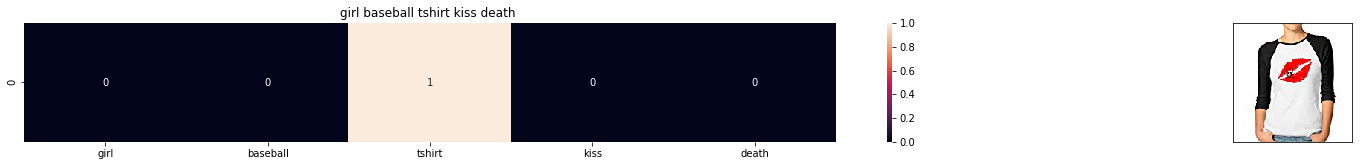

ASIN : B01IZB43Q2
Brand: TopSeeti
Title: girl baseball tshirt kiss death 
Euclidean similarity with the query image : 15007


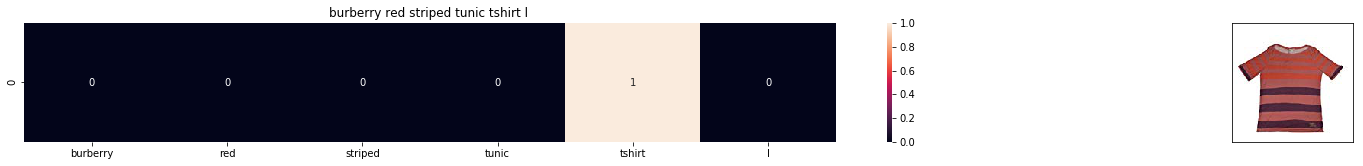

ASIN : B072YBZRNL
Brand: BURBERRY
Title: burberry red striped tunic tshirt l 
Euclidean similarity with the query image : 11762


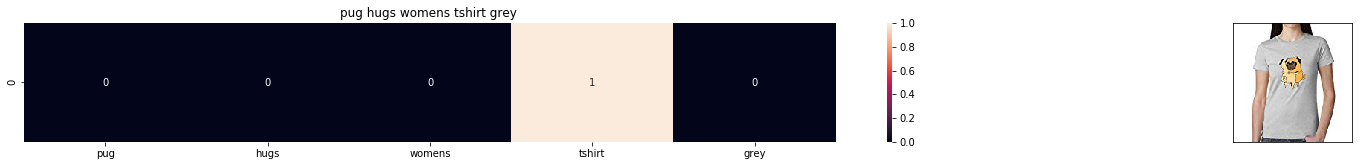

ASIN : B01FS5GGE0
Brand: Moonflow
Title: pug hugs womens tshirt grey 
Euclidean similarity with the query image : 14972


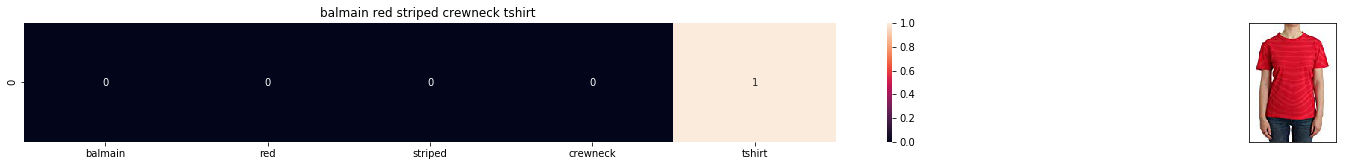

ASIN : B074G55DCV
Brand: Balmain
Title: balmain red striped crewneck tshirt 
Euclidean similarity with the query image : 6749


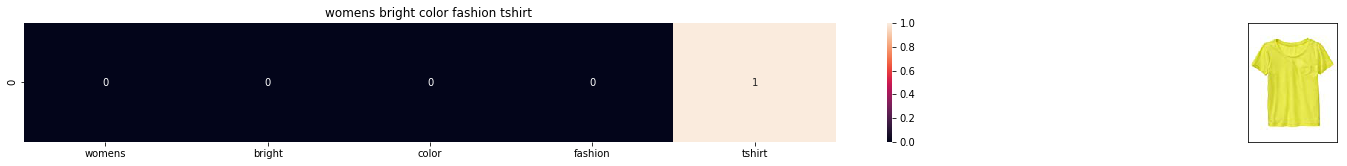

ASIN : B074KTZ1HN
Brand: Magic
Title: womens bright color fashion tshirt 
Euclidean similarity with the query image : 15385


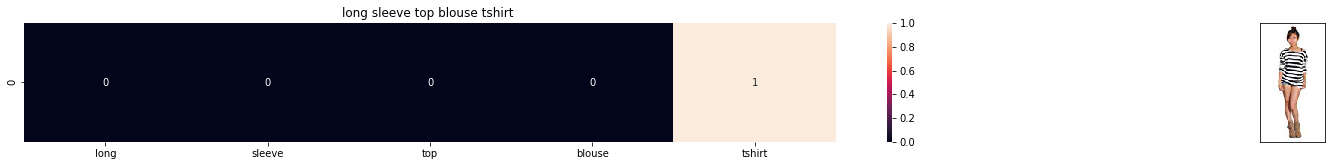

ASIN : B00KF2N5PU
Brand: Vietsbay
Title: long sleeve top blouse tshirt 
Euclidean similarity with the query image : 8452


In [62]:
def BAG_OF_WORDS_MODEL(doc_id , num_results):
    pairwise_dist = pairwise_distances(title_features, title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    df_idx = list(data.index[indices])
    
    for i in range(0, len(indices)):
        get_result(indices[i], data['title'].loc[df_idx[0]], \
                   data['title'].loc[df_idx[i]], data['medium_image_url'].loc[df_idx[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_idx[i]])
        print ('Brand:', data['brand'].loc[df_idx[i]])
        print ('Title:', data['title'].loc[df_idx[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*10)
        
## call bag of words model
BAG_OF_WORDS_MODEL(12566, 20)
        
        

# IDF based product similarity


In [45]:
idf_title_vect = CountVectorizer()
idf_title_features = idf_title_vect.fit_transform(data['title'])


In [47]:
def conatins_word(word):
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    return math.log(data.shape[0]/(conatins_word(word)))


In [49]:
## convert values to float
idf_title_features = idf_title_features.astype(np.float)

for i in idf_title_vect.vocabulary_.keys():
    idf_val = idf(i)
    
    for j in idf_title_features[:,idf_title_vect.vocabulary_[i]].nonzero()[0]:
        idf_title_features[j, idf_title_vect.vocabulary_[i]] = idf_val



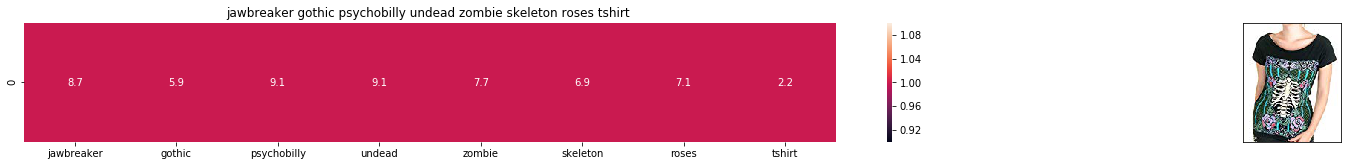

ASIN : B01D3R5VXC
Brand : Jawbreaker
euclidean distance from the given image : 0.0


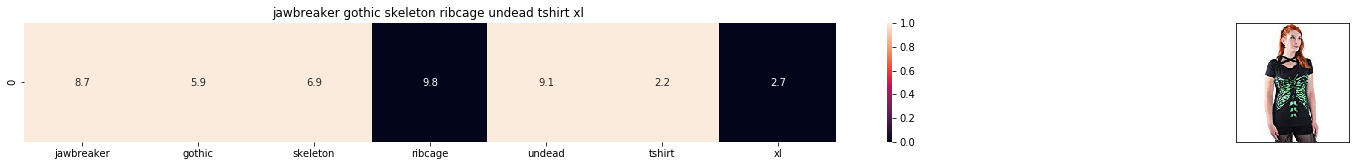

ASIN : B072YV132Q
Brand : Jawbreaker
euclidean distance from the given image : 17.1947961170925


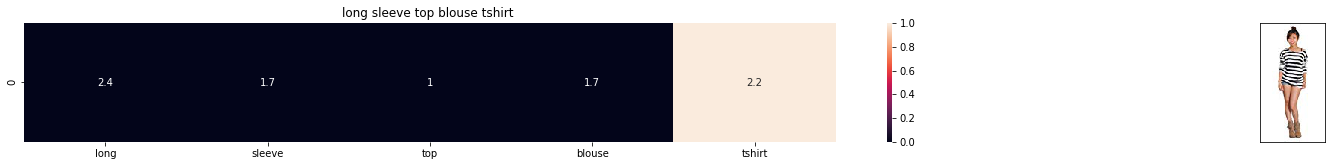

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 21.11177322505736


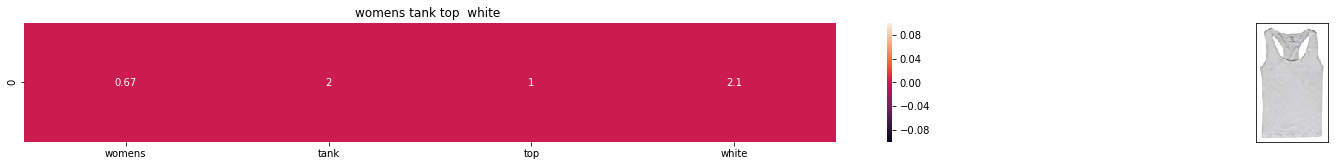

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 21.156267856076596


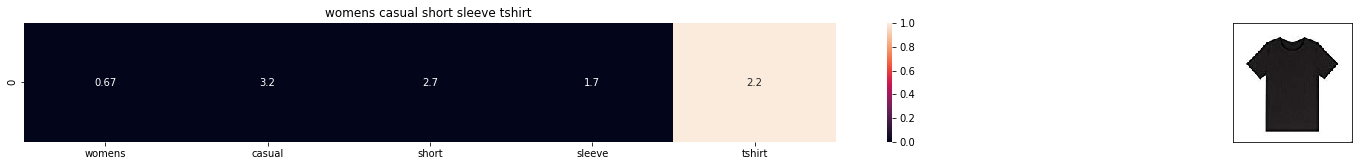

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 21.30833267443893


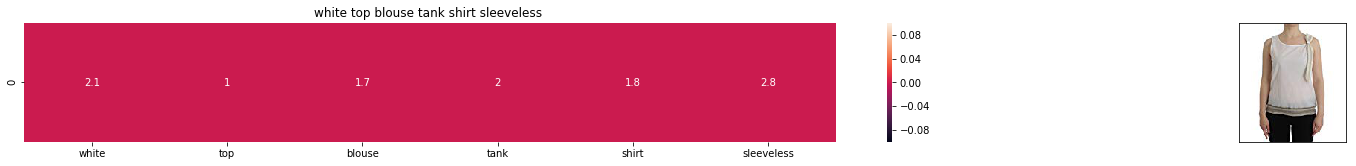

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 21.471713740142818


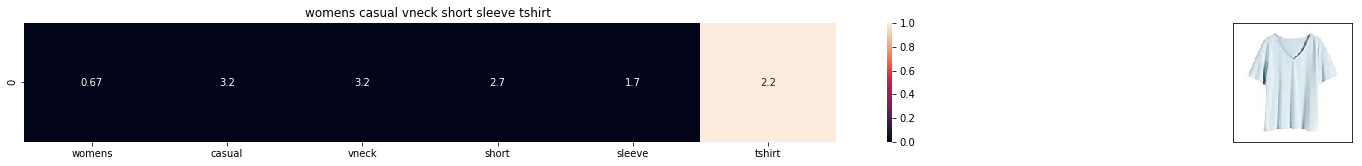

ASIN : B074V45DCX
Brand : Rain
euclidean distance from the given image : 21.5534634027502


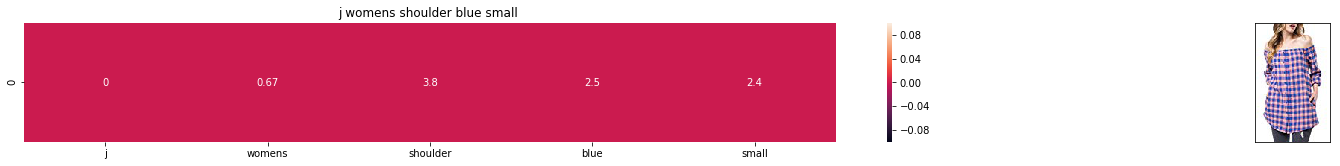

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 21.559899723299925


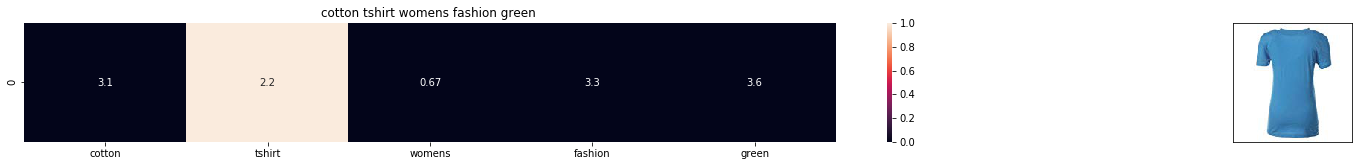

ASIN : B073GJGVBN
Brand : Ivan Levi
euclidean distance from the given image : 21.616228483567316


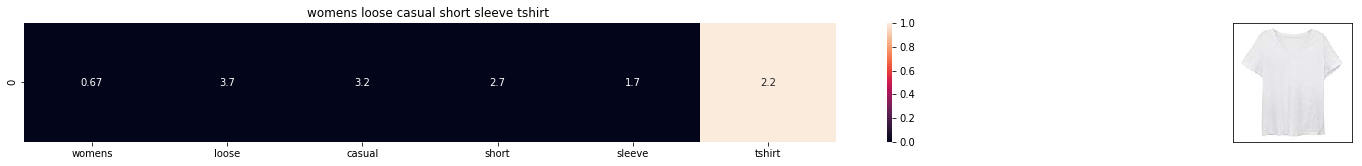

ASIN : B07567M2M9
Brand : Sunshine
euclidean distance from the given image : 21.6336004058726


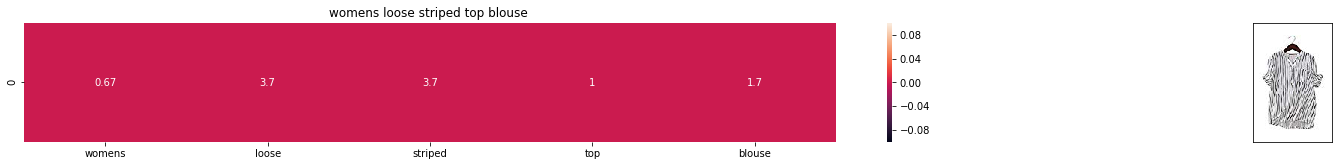

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 21.683154569596358


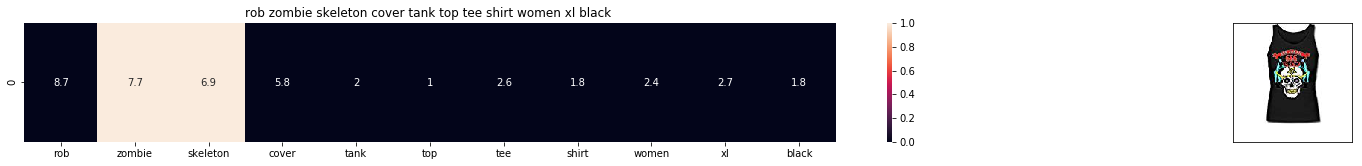

ASIN : B01HJ8S7ZU
Brand : WOKE
euclidean distance from the given image : 21.70237718202328


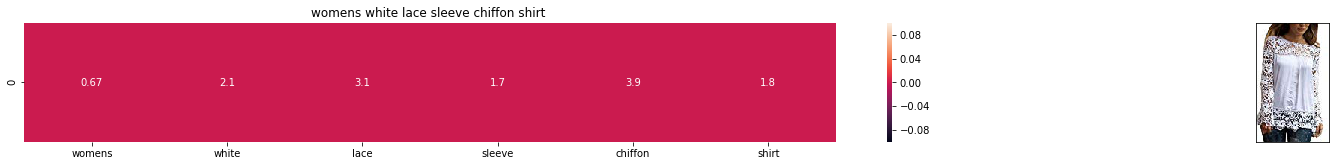

ASIN : B073JWSM1V
Brand : Fuming
euclidean distance from the given image : 21.76151913344808


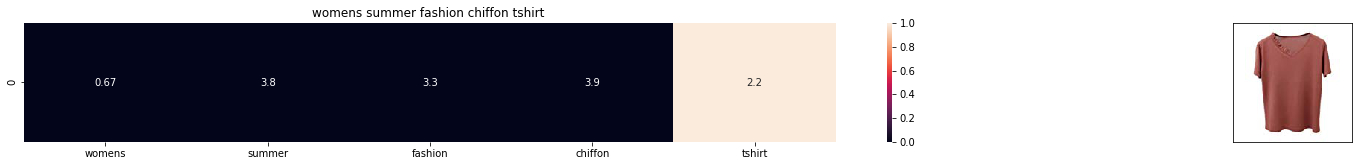

ASIN : B074K92RZR
Brand : Sunshine
euclidean distance from the given image : 21.76967856863172


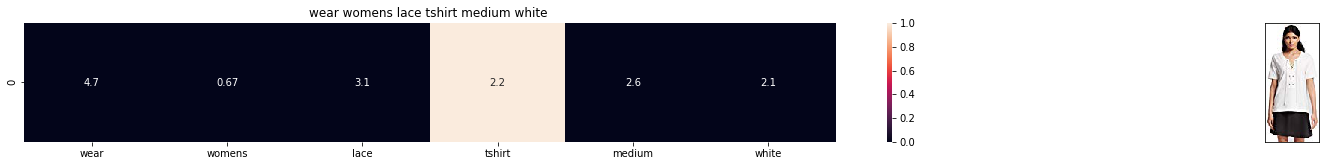

ASIN : B01MZZF0BB
Brand : Who What Wear
euclidean distance from the given image : 21.81711457683467


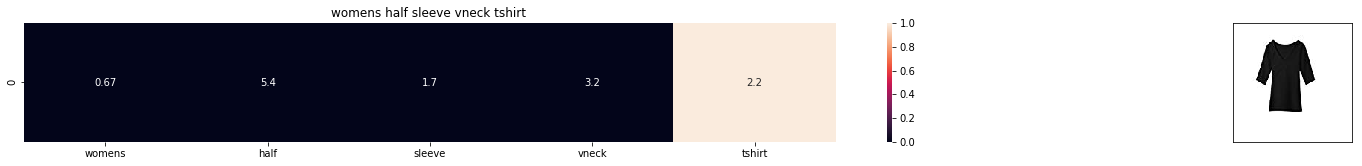

ASIN : B074W2LPYR
Brand : SNOW
euclidean distance from the given image : 21.829752505581606


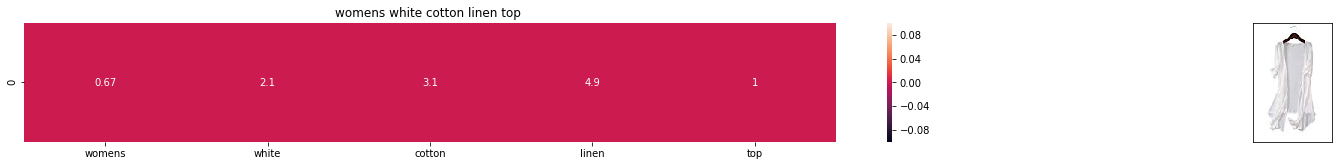

ASIN : B00ZZPR4Y0
Brand : HP-LEISURE
euclidean distance from the given image : 21.85148199617511


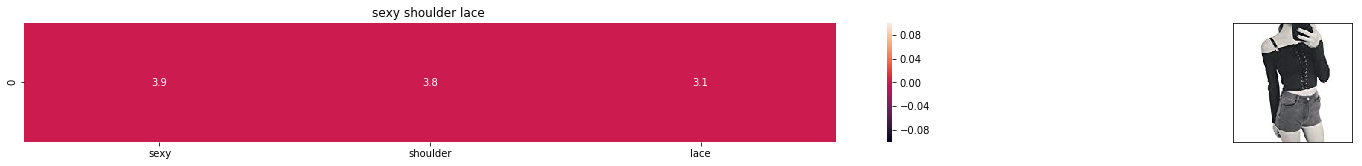

ASIN : B01JVWUB3S
Brand : bylexie
euclidean distance from the given image : 21.85155793686858


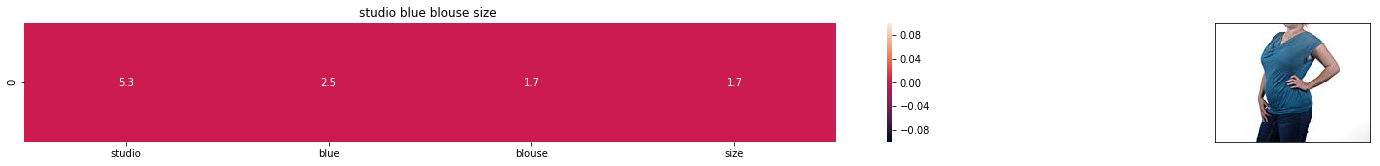

ASIN : B016P80OKQ
Brand : Studio M
euclidean distance from the given image : 21.85642801252216


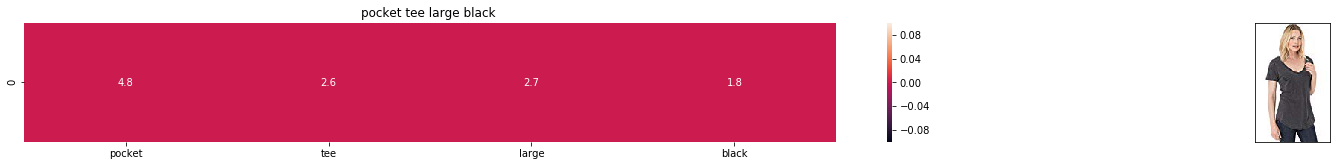

ASIN : B017I2YWUQ
Brand : Z SUPPLY
euclidean distance from the given image : 21.86310659027229


In [63]:
def idf_model(doc_id, results):
    pairwise_dist = pairwise_distances(idf_title_features, idf_title_features[doc_id])
    idx = np.argsort(pairwise_dist.flatten())[0:results]
    pdists = np.sort(pairwise_dist.flatten())[0:results]
    df_idx = list(data.index[idx])
    
    for i in range(0, len(idx)):
        get_result(idx[i],data['title'].loc[df_idx[0]], data['title'].loc[df_idx[i]], data['medium_image_url'].loc[df_idx[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_idx[i]])
        print('Brand :',data['brand'].loc[df_idx[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*50)
        
        
        
idf_model(12566,20)


# TEXT SEMANTICS BASED PRODUCT SIMILARITY


In [67]:
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
# import pickle

##download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

# model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)



In [93]:
## load the word to vec model
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)



In [97]:
## utility fucntions for word to vec based product similarity
def get_word_vecs(sentecne , doc_id, m_name):
    vec = []
    for i in sentecne.split():
        if i in vocab:
            if m_name=='weighted' and i in idf_title_vect.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vect.vocabulary_[i]] * model[i])
            elif m_name=='avg':
                vec.append(model[i])
        else:
            vec.append(np.zeros(shape = (300,)))
    return np.array(vec)

def get_distance(vec1, vec2):
    final_dist = []
    for i in vec1:
        dist=[]
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)

def heat_map_w2vec(sent1, sent2, url, doc_id1, doc_id2,model):
    s1_vec = get_word_vecs(sent1, doc_id1, model)
    s2_vec = get_word_vecs(sent2, doc_id2, model)
    s1_s2_dist = get_distance(s1_vec, s2_vec) 
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sent2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sent1.split())
    # set title as recommended apparels title
    ax.set_title(sent2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)

    plt.show()
        


In [98]:
# vocab = stores all the words that are there in google w2v model

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    
    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vect.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vect.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [99]:
doc_id = 0
w2vec_title_weight = []
## for each title get a vector representation
for i in data['title']:
    w2vec_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id +=1
w2vec_title_weight = np.array(w2vec_title_weight)

In [100]:
### weighted similarity using brand and color using Word2vec and IDF(Inverse Document Frequecny) model


data['brand'].fillna(value = "Not Given" , inplace = True)
## replace space with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ","-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectors = CountVectorizer()
brand_features = brand_vectors.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vector = CountVectorizer()
color_features = color_vector.fit_transform(colors)

extra_features = hstack((brand_features , type_features , color_features)).tocsr()

In [101]:
def heat_map_w2v_extra_features(sentence1 , sentence2,url, doc_id1, doc_id2, df_id1, df_id2,model):
    s1_vec = get_word_vecs(sentence1, doc_id1, model)
    s2_vec = get_word_vecs(sentence2, doc_id2, model)

    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # divide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax1.set_title(sentence2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_image(url, ax2, fig)
    
    plt.show()
    

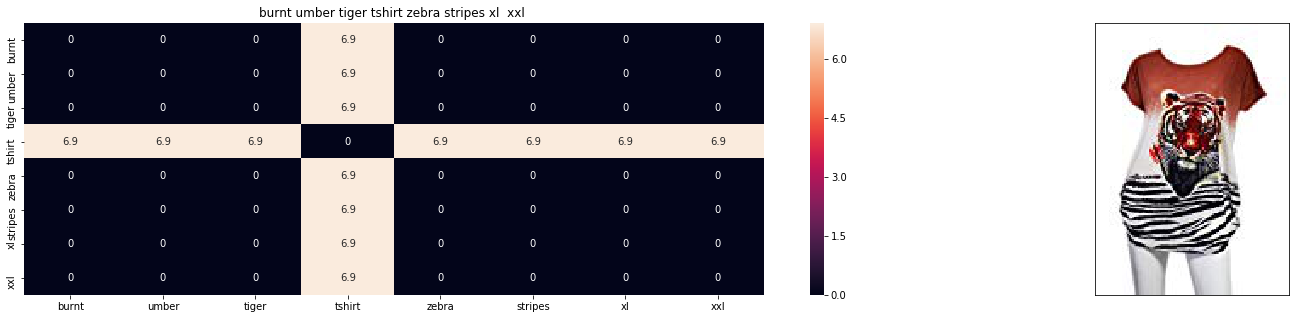

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


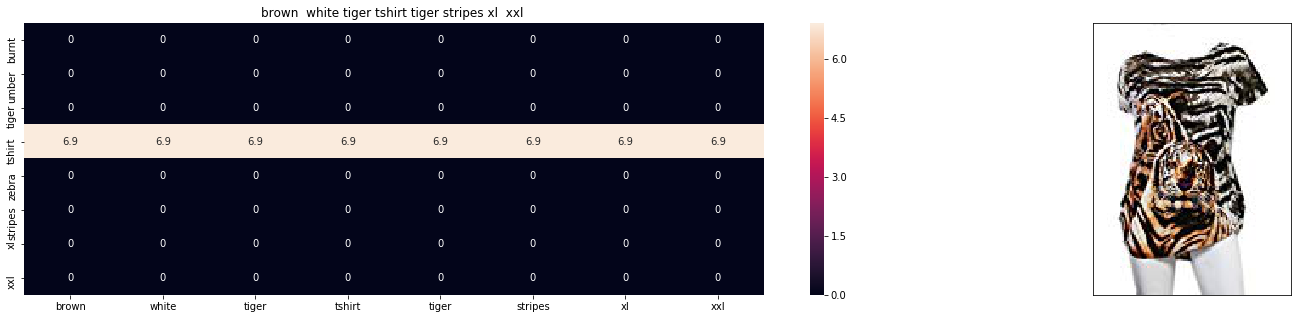

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 0.4317950248718262


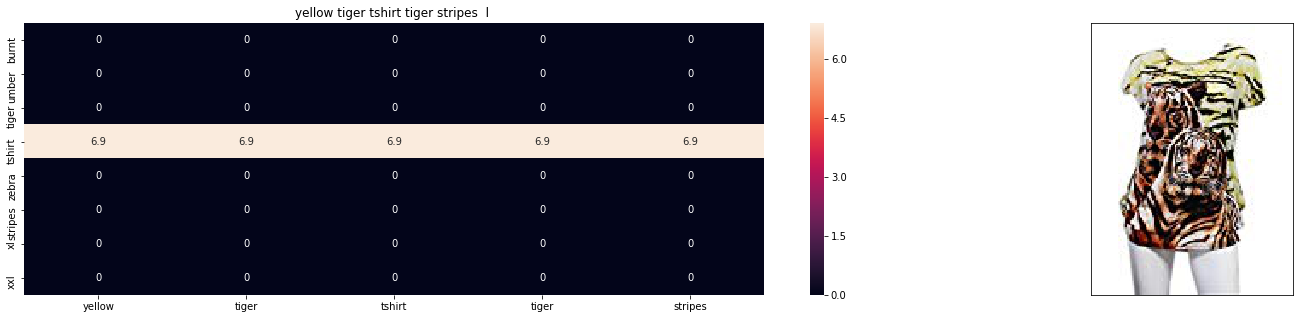

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 1.1389018060583738


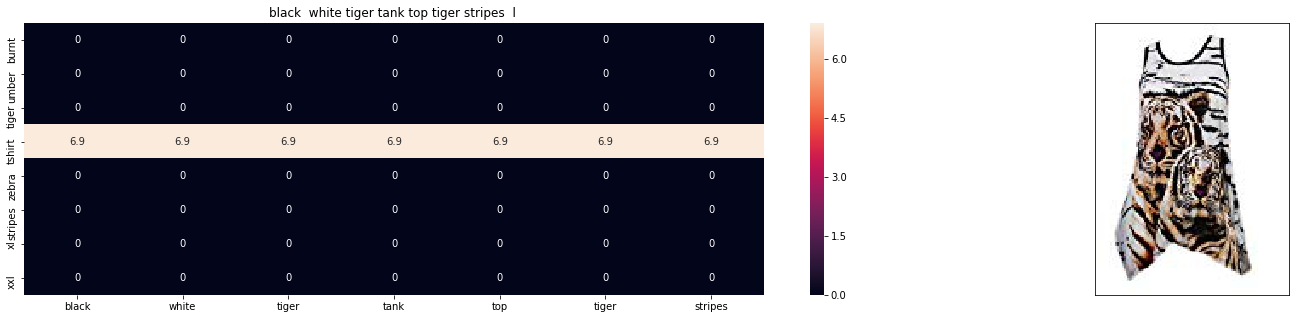

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 1.1389018060583738


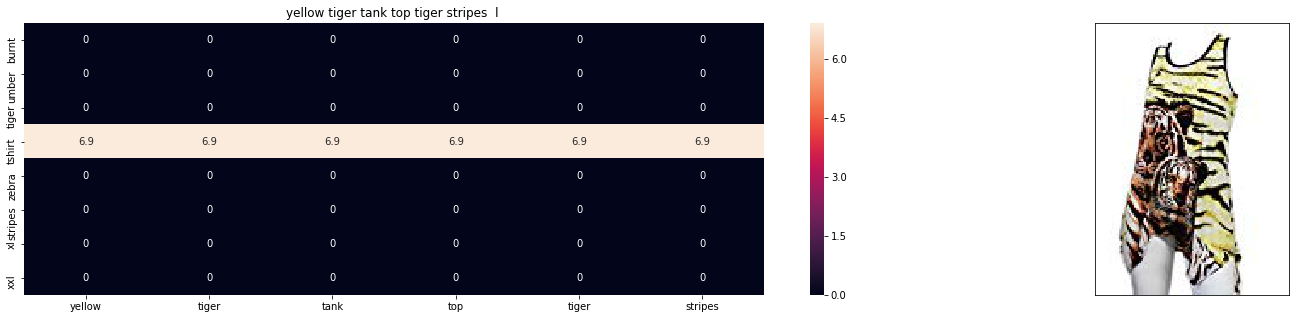

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 1.1389018060583738


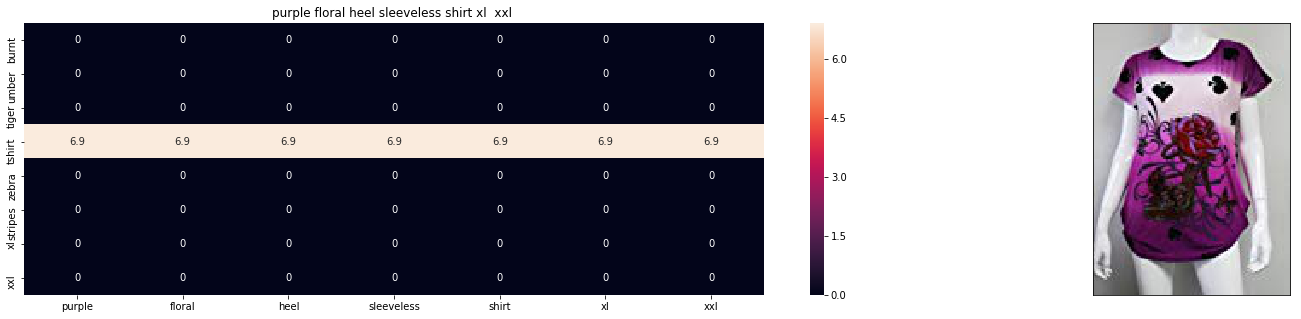

ASIN : B00JV63VC8
Brand : Si Row
euclidean distance from input : 1.1389018060583738


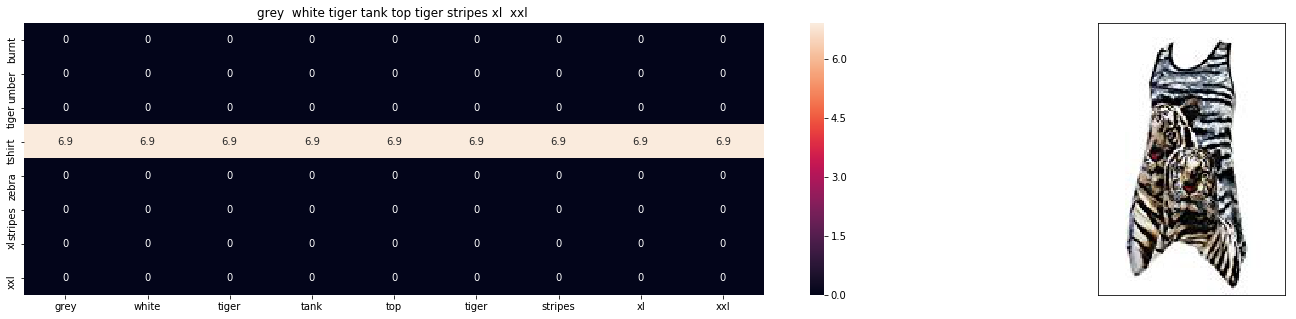

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 1.1389018060583738


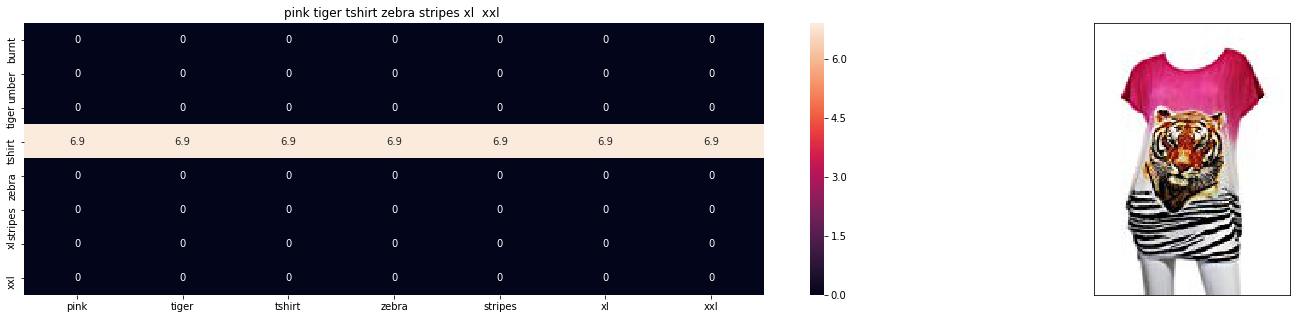

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 1.1389018060583738


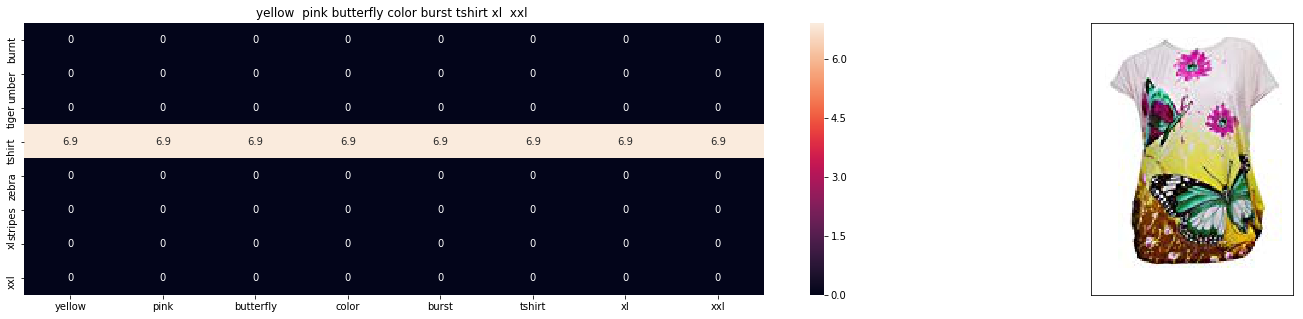

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from input : 1.1389018060583738


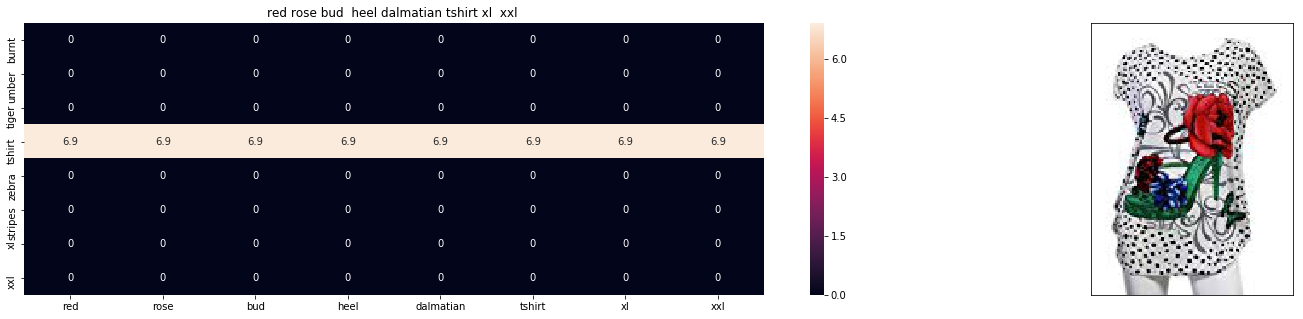

ASIN : B00JXQABB0
Brand : Si Row
euclidean distance from input : 1.1389018060583738


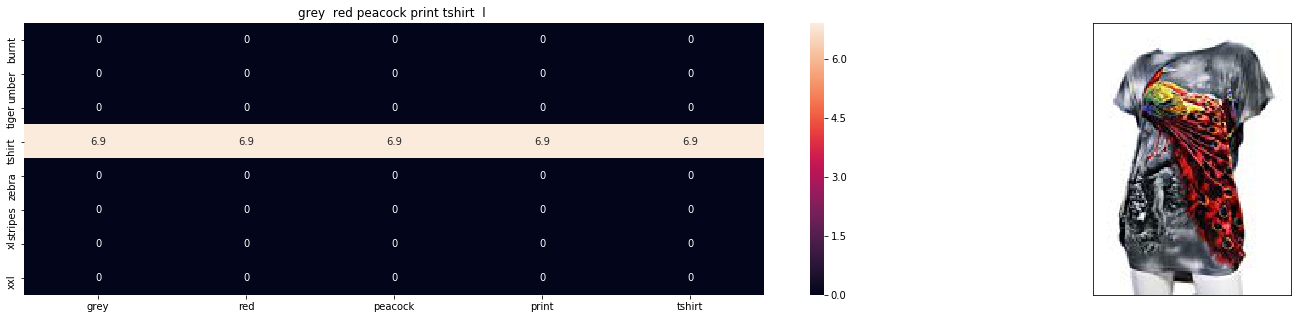

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from input : 1.1389018060583738


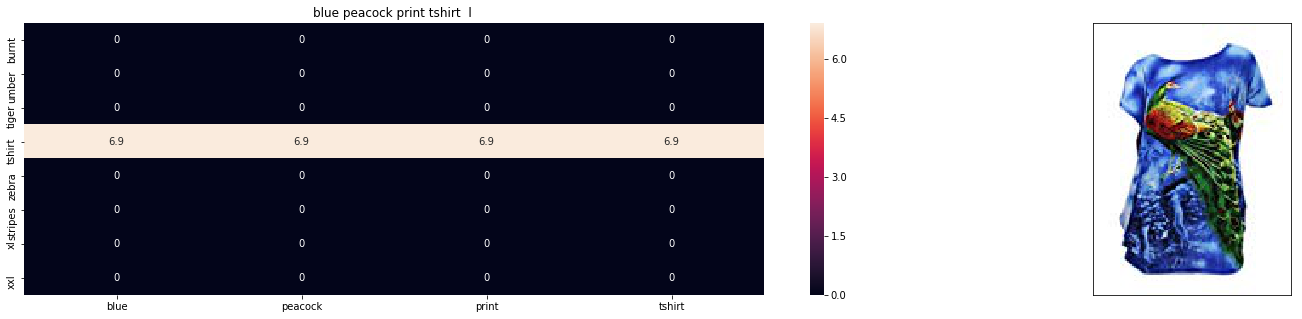

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 1.1389018060583738


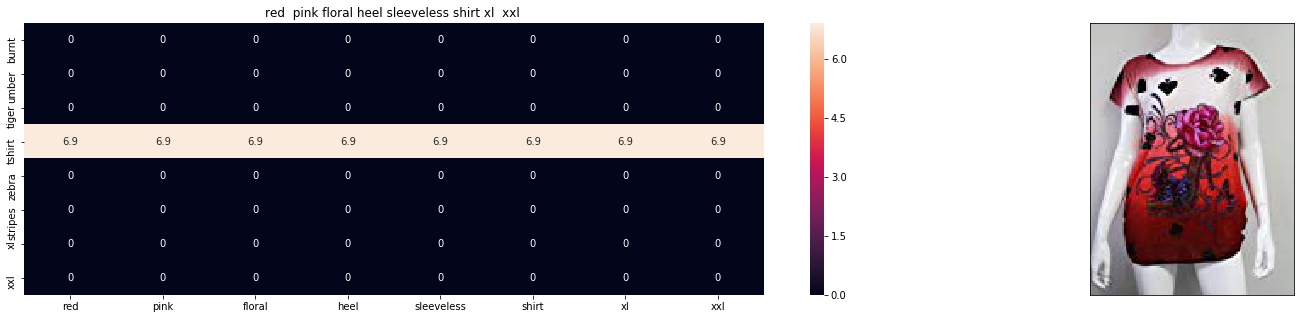

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from input : 1.1389018060583738


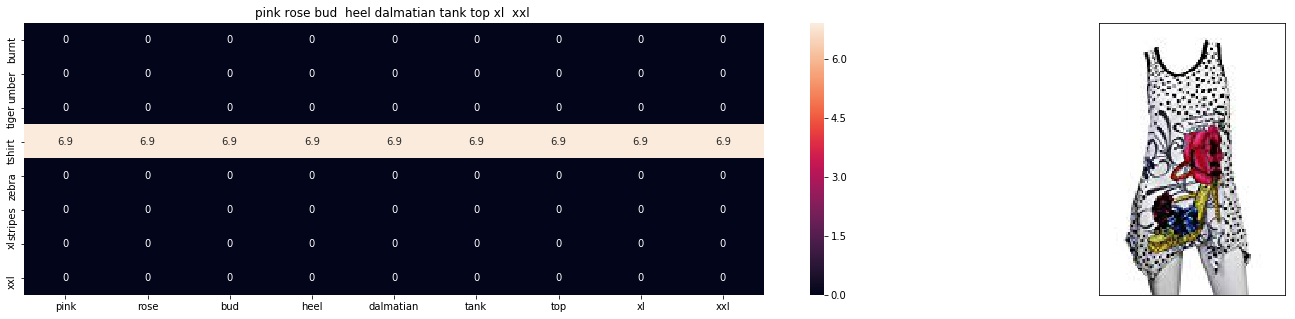

ASIN : B00JXQAX2C
Brand : Si Row
euclidean distance from input : 1.1389018060583738


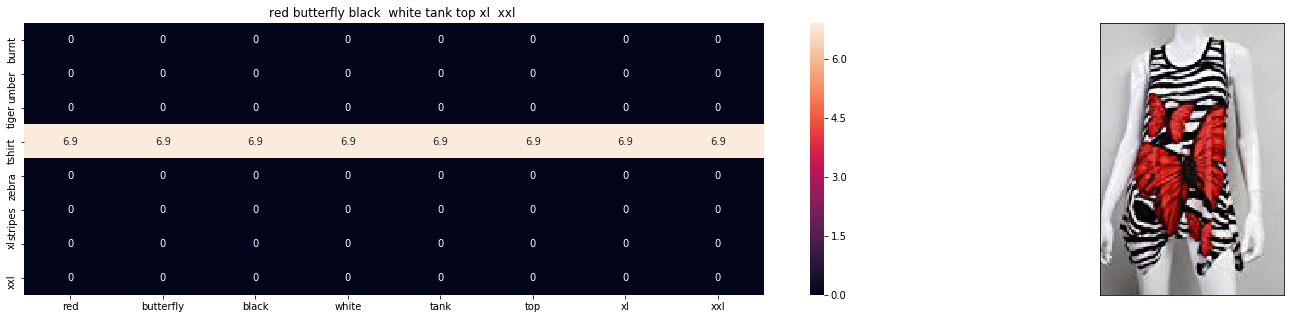

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from input : 1.1389018060583738


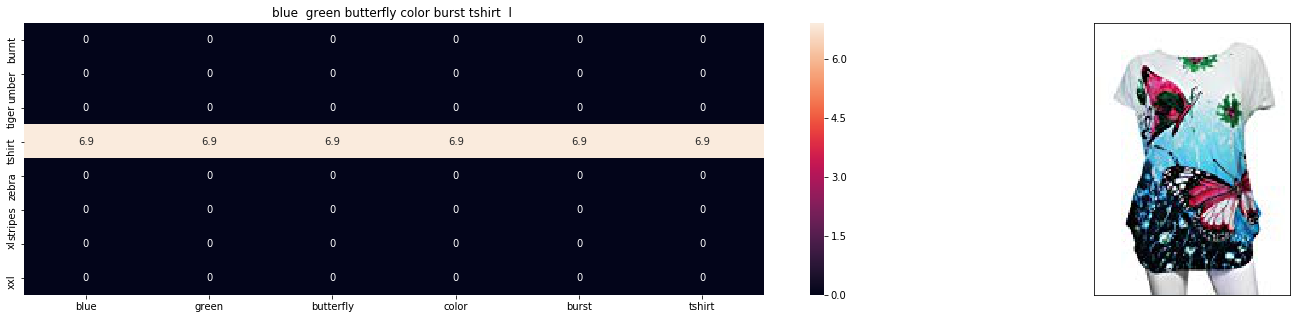

ASIN : B00JXQC0C8
Brand : Si Row
euclidean distance from input : 1.1389018060583738


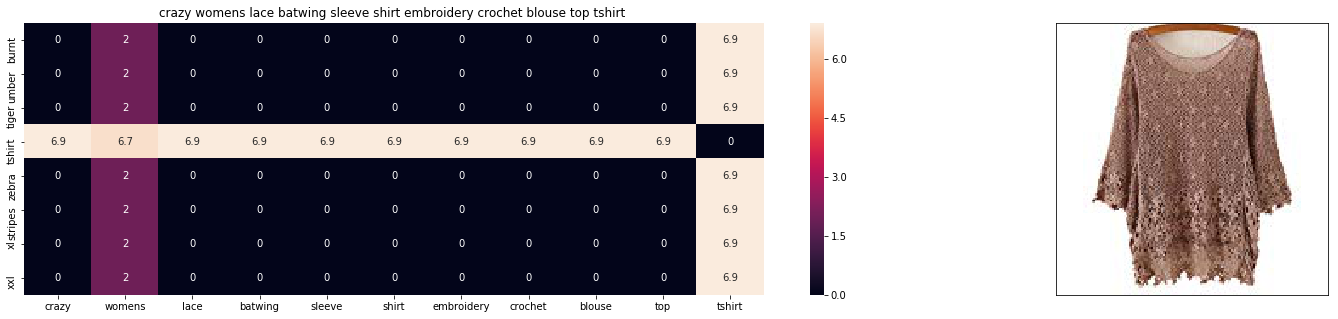

ASIN : B00ZC37KK8
Brand : Crazy
euclidean distance from input : 1.2458910062669848


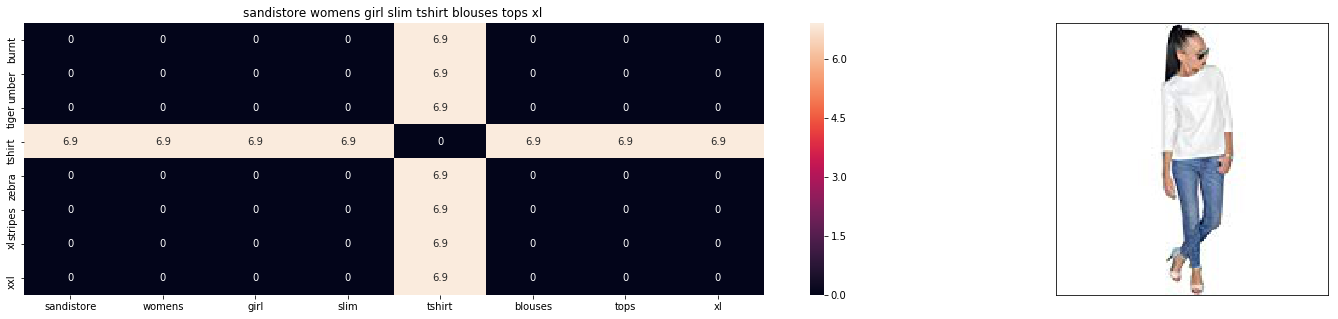

ASIN : B00ZKZBEOQ
Brand : Sandistore
euclidean distance from input : 1.3228756555322954


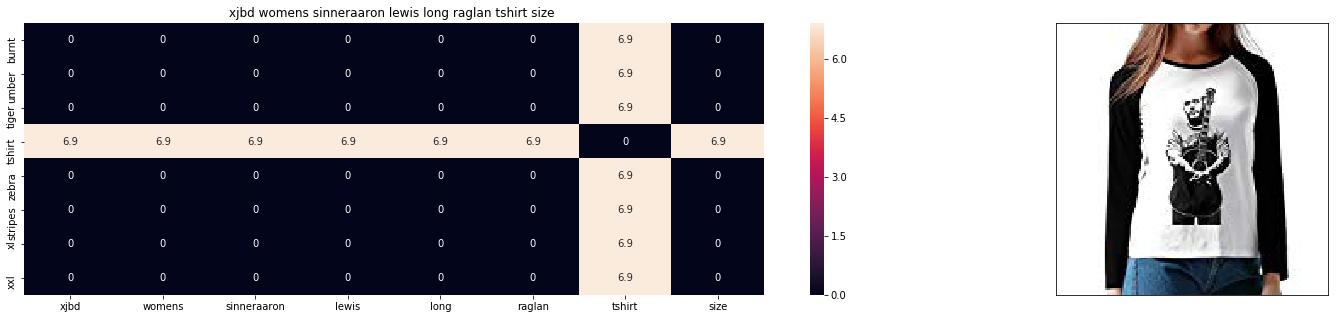

ASIN : B01M4GE3AM
Brand : XJBD
euclidean distance from input : 1.3228756555322954


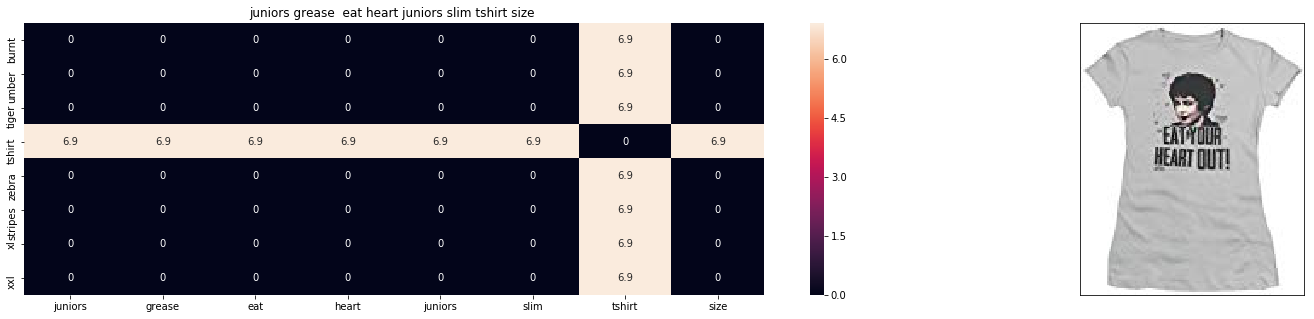

ASIN : B00IQRAH70
Brand : Grease
euclidean distance from input : 1.3228756555322954


In [102]:
def w2v_idf_extra_features(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2vec_title_weight, w2vec_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_extra_features(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*50)

w2v_idf_extra_features(12566, 5, 5, 20)

In [89]:
# Deep Learning Image similarity using CNN(VGG16)
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


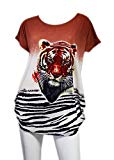

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 6.32596e-06
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


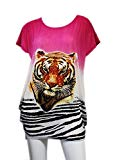

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.05017
Amazon Url: www.amzon.com/dp/B00JXQASS6


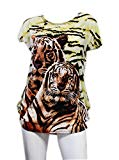

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.261116
Amazon Url: www.amzon.com/dp/B00JXQCUIC


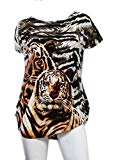

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.000156
Amazon Url: www.amzon.com/dp/B00JXQCWTO


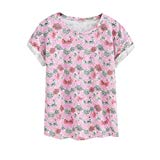

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.38248
Amazon Url: www.amzon.com/dp/B071FCWD97


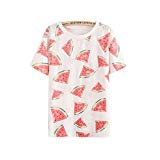

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.71842
Amazon Url: www.amzon.com/dp/B01JUNHBRM


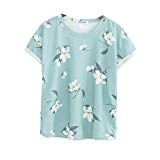

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.90206
Amazon Url: www.amzon.com/dp/B071SBCY9W


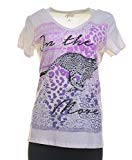

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.046482
Amazon Url: www.amzon.com/dp/B01CUPYBM0


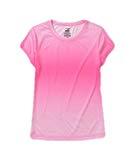

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.101837
Amazon Url: www.amzon.com/dp/B01F7PHXY8


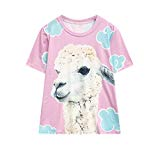

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.118866
Amazon Url: www.amzon.com/dp/B01I80A93G


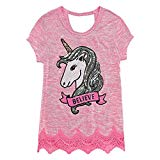

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 48.13122
Amazon Url: www.amzon.com/dp/B0177DM70S


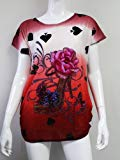

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 48.16945
Amazon Url: www.amzon.com/dp/B00JV63QQE


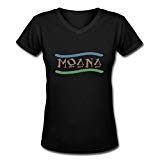

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 48.256786
Amazon Url: www.amzon.com/dp/B01LX6H43D


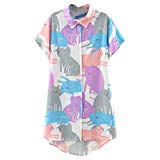

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 48.265686
Amazon Url: www.amzon.com/dp/B01CR57YY0


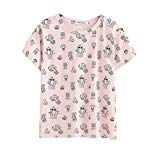

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 48.362602
Amazon Url: www.amzon.com/dp/B071WYLBZS


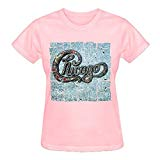

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 48.383606
Amazon Url: www.amzon.com/dp/B01GXAZTRY


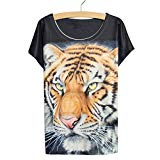

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 48.449356
Amazon Url: www.amzon.com/dp/B010NN9RXO


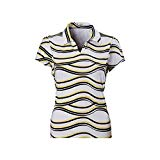

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 48.47889
Amazon Url: www.amzon.com/dp/B01MPX6IDX


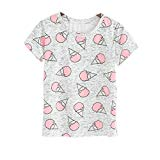

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 48.557957
Amazon Url: www.amzon.com/dp/B0734GRKZL


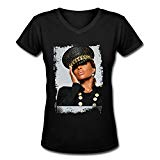

Product Title:  uswomens mary j blige without tshirts shirt 
Euclidean Distance from input image: 48.614372
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [90]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)